In [1]:
from sklearn.datasets import fetch_lfw_people
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.layers import BatchNormalization, Dropout
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# **Data Collection**

In [3]:

lfw = fetch_lfw_people(color=True, min_faces_per_person=3)  
X = lfw.images
y = lfw.target
names = lfw.target_names
print(X.shape)        
print(len(names))     
print(set(y))         
print(names[y[0]])    

(7606, 62, 47, 3)
901
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

# **Preprocessing**

In [4]:

X = lfw.images.astype("float32") / 255.0
X_resized = np.array([tf.image.resize(img, (32, 32)).numpy() for img in X])  


X_train, X_test, y_train, y_test = train_test_split(
    X_resized, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)

Train set: (6084, 32, 32, 3) Test set: (1522, 32, 32, 3)


# **Generate Triplets**

In [5]:
def generate_triplets(X, y, num_triplets=5000):
    triplets = []
    labels = np.unique(y)

    
    class_to_indices = {}
    for c in labels:
        class_to_indices[c] = np.where(y == c)[0]

    
    valid_classes = [c for c in labels if len(class_to_indices[c]) >= 2]

    for _ in range(num_triplets):
        anchor_label = random.choice(valid_classes)
        anchor_idx, pos_idx = np.random.choice(class_to_indices[anchor_label], 2, replace=False)

        
        neg_classes = [c for c in valid_classes if c != anchor_label]
        neg_label = random.choice(neg_classes)
        neg_idx = np.random.choice(class_to_indices[neg_label])

        triplets.append((X[anchor_idx], X[pos_idx], X[neg_idx]))

    return np.array(triplets)


train_triplets = generate_triplets(X_train, y_train, num_triplets=30000)
print("Train triplets:", train_triplets.shape)


Train triplets: (30000, 3, 32, 32, 3)


# **CNN**

In [6]:
def embedding_model(input_shape=(32, 32, 3), embedding_dim=128):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = Dropout(0.4)(x)

    # Dense embedding
    x = layers.Flatten()(x)
    x = layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = layers.Dense(embedding_dim)(x)

    # L2-normalized output
    outputs = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    return Model(inputs, outputs)

embedder = embedding_model()
embedder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1849

# **Triplet loss**

In [7]:
def triplet_loss(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        return K.mean(K.maximum(pos_dist - neg_dist + margin, 0))
    return loss

In [8]:
def build_triplet_model(embedder, input_shape=(32,32, 3)):
    anchor_input = layers.Input(input_shape)
    positive_input = layers.Input(input_shape)
    negative_input = layers.Input(input_shape)

    anchor_emb = embedder(anchor_input)
    pos_emb = embedder(positive_input)
    neg_emb = embedder(negative_input)

    merged = layers.Concatenate(axis=1)([anchor_emb, pos_emb, neg_emb])

    # Reshape to have a third dimension
    output = layers.Reshape((3, embedder.output_shape[-1]))(merged)

    model = Model([anchor_input, positive_input, negative_input], output)
    return model 

In [9]:
triplet_model = build_triplet_model(embedder)
triplet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=triplet_loss(margin=0.5))

anchors = train_triplets[:, 0]
positives = train_triplets[:, 1]
negatives = train_triplets[:, 2]

# Generate validation triplets
val_triplets = generate_triplets(X_test, y_test, num_triplets=5000)
val_anchors = val_triplets[:, 0]
val_positives = val_triplets[:, 1]
val_negatives = val_triplets[:, 2]

# Add callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)



# **Train the model**

In [10]:

history = triplet_model.fit(
    [anchors, positives, negatives],
    np.zeros(len(anchors)),  # dummy labels
    batch_size=32,
    epochs=30,
    validation_data=([val_anchors, val_positives, val_negatives], np.zeros(len(val_anchors))),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/30

938/938 [==============================] - 26s 26ms/step - loss: 0.8438 - val_loss: 0.7681 - lr: 1.0000e-04
Epoch 2/30
938/938 [==============================] - 24s 26ms/step - loss: 0.7219 - val_loss: 0.6827 - lr: 1.0000e-04
Epoch 3/30
938/938 [==============================] - 26s 28ms/step - loss: 0.6364 - val_loss: 0.5966 - lr: 1.0000e-04
Epoch 4/30
938/938 [==============================] - 29s 30ms/step - loss: 0.5613 - val_loss: 0.5353 - lr: 1.0000e-04
Epoch 5/30
938/938 [==============================] - 24s 25ms/step - loss: 0.5028 - val_loss: 0.4790 - lr: 1.0000e-04
Epoch 6/30
938/938 [==============================] - 24s 26ms/step - loss: 0.4470 - val_loss: 0.4234 - lr: 1.0000e-04
Epoch 7/30
938/938 [==============================] - 24s 26ms/step - loss: 0.4000 - val_loss: 0.3888 - lr: 1.0000e-04
Epoch 8/30
938/938 [==============================] - 24s 26ms/step - loss: 0.3576 - val_loss: 0.3660 - lr: 1.0000e-04
Epoch 9/30
938/938 [===========================

# **Evaluation**

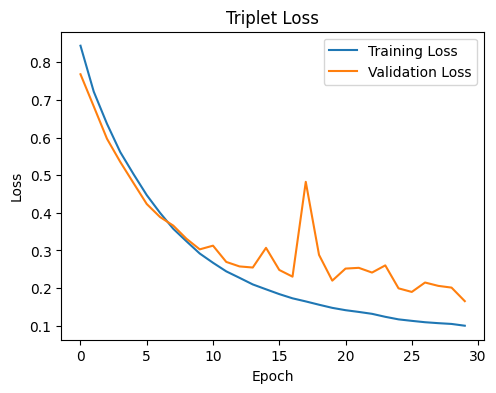

In [11]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Triplet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [12]:
def evaluate_verification(embedder, X, y, num_pairs=1000, threshold=0.7):
    pairs = []
    labels = []

    unique_classes = np.unique(y)
    # Precompute indices for each class
    class_to_indices = {c: np.where(y == c)[0] for c in unique_classes}

    # Filter classes with at least 2 samples
    valid_classes = [c for c in unique_classes if len(class_to_indices[c]) >= 2]

    for _ in range(num_pairs):
        if np.random.rand() > 0.5:  # positive pair
            c = np.random.choice(valid_classes)
            a, b = np.random.choice(class_to_indices[c], 2, replace=False)
            pairs.append((X[a], X[b]))
            labels.append(1)
        else:  # negative pair
            c1, c2 = np.random.choice(valid_classes, 2, replace=False)
            a = np.random.choice(class_to_indices[c1])
            b = np.random.choice(class_to_indices[c2])
            pairs.append((X[a], X[b]))
            labels.append(0)

    X1 = np.array([p[0] for p in pairs])
    X2 = np.array([p[1] for p in pairs])
    y_true = np.array(labels)

    emb1 = embedder.predict(X1, verbose=0)
    emb2 = embedder.predict(X2, verbose=0)

    distances = np.linalg.norm(emb1 - emb2, axis=1)
    y_pred = (distances < threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)

    # Calculate precision and recall
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return acc, precision, recall, distances, y_true

# Evaluate with different thresholds to find the optimal one
thresholds = np.arange(0.5, 1.0, 0.05)
best_threshold = 0.7
best_acc = 0

for threshold in thresholds:
    train_acc, train_precision, train_recall, _, _ = evaluate_verification(embedder, X_train, y_train, num_pairs=2000, threshold=threshold)
    if train_acc > best_acc:
        best_acc = train_acc
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.2f}")

Best threshold: 0.95


In [13]:
#  with the best threshold
train_acc, train_precision, train_recall, _, _ = evaluate_verification(embedder, X_train, y_train, num_pairs=2000, threshold=best_threshold)
test_acc, test_precision, test_recall, _, _ = evaluate_verification(embedder, X_test, y_test, num_pairs=2000, threshold=best_threshold)

print(f"Verification Accuracy (Train): {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
print(f"Verification Accuracy (Test): {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

Verification Accuracy (Train): 0.9175, Precision: 0.9266, Recall: 0.9030
Verification Accuracy (Test): 0.7770, Precision: 0.8872, Recall: 0.6322


# **Save The Model**

In [14]:

embedder.save('lfw_embedding_model.h5')
print("Model saved as 'lfw_embedding_model.h5'")

Model saved as 'lfw_embedding_model.h5'


d:\Rawan\NTI\final project\Face-Finder-App\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
embedder.save_weights("lfw_embedding_model.weights.h5")

In [16]:
embedder.save("lfw_embedding_model.keras")